In [36]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import optuna
#import shap

#shap.initjs()

In [34]:
!pip install cloudpickle

Defaulting to user installation because normal site-packages is not writeable


In [2]:
geo_info = pd.read_csv('geo_info.csv', sep=';')
referer_vectors = pd.read_csv('referer_vectors.csv', sep=';')
test_users = pd.read_csv('test_users.csv', sep=';')
test = pd.read_csv('test.csv', sep=';')
train_labels = pd.read_csv('train_labels.csv', sep=';')
train = pd.read_csv('train.csv', sep=';')

In [3]:
train = train.merge(geo_info, on='geo_id', how='left')
train = train.merge(train_labels, on='user_id', how='left')
train = train.merge(referer_vectors, on='referer', how='left')

In [4]:
train['user_agent']

0         {'browser': 'Chrome Mobile', 'browser_version'...
1         {'browser': 'Chrome Mobile', 'browser_version'...
2         {'browser': 'Yandex Browser', 'browser_version...
3         {'browser': 'Chrome Mobile', 'browser_version'...
4         {'browser': 'Yandex Browser', 'browser_version...
                                ...                        
759967    {'browser': 'Opera', 'browser_version': '104.0...
759968    {'browser': 'Yandex Browser', 'browser_version...
759969    {'browser': 'Chrome Mobile', 'browser_version'...
759970    {'browser': 'Chrome', 'browser_version': '118....
759971    {'browser': 'Chrome', 'browser_version': '106....
Name: user_agent, Length: 759972, dtype: object

In [5]:
def parse_user_agent(x):
    if pd.isna(x):
        return {}
    try:
        return eval(x)
    except (ValueError, SyntaxError):
        return {}

train['parsed_user_agent'] = train['user_agent'].apply(parse_user_agent)
train['browser'] = train['parsed_user_agent'].apply(lambda x: x.get('browser', None))
train['browser_version'] = train['parsed_user_agent'].apply(lambda x: x.get('browser_version', None))
train['os'] = train['parsed_user_agent'].apply(lambda x: x.get('os', None))
train['os_version'] = train['parsed_user_agent'].apply(lambda x: x.get('os_version', None))

train.drop(columns=['parsed_user_agent'], inplace=True)

In [6]:
train['referer']

0                 https://9b48ee5/
1                 https://9b48ee5/
2         https://9634fd0/1409e548
3                 https://9b48ee5/
4                 https://9b48ee5/
                    ...           
759967            https://8807153/
759968    https://6a81948/14217aec
759969    https://bc69dee/15f0df79
759970    https://72879b4/131bd916
759971            https://b56ea20/
Name: referer, Length: 759972, dtype: object

In [7]:
train['referer'].str.lstrip('https://').str.rstrip('/')

0                  9b48ee5
1                  9b48ee5
2         9634fd0/1409e548
3                  9b48ee5
4                  9b48ee5
                ...       
759967             8807153
759968    6a81948/14217aec
759969    bc69dee/15f0df79
759970    72879b4/131bd916
759971             b56ea20
Name: referer, Length: 759972, dtype: object

In [8]:
train[['domain', 'path']] = train['referer'].str.lstrip('https://').str.rstrip('/').str.split('/', n=1, expand=True)

In [9]:
train[['domain', 'path']]

,domain,path
0,9b48ee5,None
1,9b48ee5,None
2,9634fd0,1409e548
3,9b48ee5,None
4,9b48ee5,None
...,...,...
759967,8807153,None
759968,6a81948,14217aec
759969,bc69dee,15f0df79
759970,72879b4,131bd916


In [10]:
train.describe()

,request_ts,geo_id,target,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9
count,7.599720e+05,759972.000000,601290.000000,759972.000000,759972.000000,759972.000000,759972.000000,759972.000000,759972.000000,759972.000000,759972.000000,759972.000000,759972.000000
mean,1.700997e+09,4512.333150,0.478501,10488.175567,6709.729922,6090.511771,3524.435031,9277.808673,6865.844206,3273.977675,4556.063791,4410.482493,6675.454247
std,2.186900e+04,2566.905428,0.499538,6588.858800,7396.260052,7665.740315,7186.441631,7521.343600,6014.961172,7736.437506,7517.385372,9274.927179,11382.516555
min,1.700946e+09,1.000000,0.000000,-18219.000000,-23128.000000,-23805.000000,-25176.000000,-23683.000000,-24827.000000,-22799.000000,-27316.000000,-30698.000000,-21254.000000
25%,1.700982e+09,2521.000000,0.000000,6616.000000,1189.000000,2581.000000,-312.000000,4941.000000,3498.000000,-2646.000000,224.000000,2341.000000,13.000000
50%,1.701000e+09,3663.000000,0.000000,11243.000000,6814.000000,8584.000000,4814.000000,8150.000000,6679.000000,2607.000000,7012.000000,5312.000000,7684.000000
75%,1.701015e+09,6430.000000,1.000000,14837.000000,12922.000000,10640.000000,9329.000000,13395.000000,10824.000000,9977.000000,9459.000000,9516.000000,15189.000000
max,1.701032e+09,9997.000000,1.000000,31553.000000,27588.000000,30442.000000,24147.000000,28988.000000,29384.000000,26444.000000,22388.000000,25552.000000,26948.000000


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759972 entries, 0 to 759971
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   request_ts       759972 non-null  int64  
 1   user_id          759972 non-null  object 
 2   referer          759972 non-null  object 
 3   geo_id           759972 non-null  int64  
 4   user_agent       759971 non-null  object 
 5   country_id       759972 non-null  object 
 6   region_id        697990 non-null  object 
 7   timezone_id      759972 non-null  object 
 8   target           601290 non-null  float64
 9   component0       759972 non-null  int64  
 10  component1       759972 non-null  int64  
 11  component2       759972 non-null  int64  
 12  component3       759972 non-null  int64  
 13  component4       759972 non-null  int64  
 14  component5       759972 non-null  int64  
 15  component6       759972 non-null  int64  
 16  component7       759972 non-null  int6

In [12]:
train = train[~train['target'].isna()]

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601290 entries, 0 to 601289
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   request_ts       601290 non-null  int64  
 1   user_id          601290 non-null  object 
 2   referer          601290 non-null  object 
 3   geo_id           601290 non-null  int64  
 4   user_agent       601289 non-null  object 
 5   country_id       601290 non-null  object 
 6   region_id        550670 non-null  object 
 7   timezone_id      601290 non-null  object 
 8   target           601290 non-null  float64
 9   component0       601290 non-null  int64  
 10  component1       601290 non-null  int64  
 11  component2       601290 non-null  int64  
 12  component3       601290 non-null  int64  
 13  component4       601290 non-null  int64  
 14  component5       601290 non-null  int64  
 15  component6       601290 non-null  int64  
 16  component7       601290 non-null  int64  
 

In [14]:
train['target'] = train['target'].astype(int)

In [15]:
train = train.drop(['geo_id', 'user_agent', 'referer'], axis=1)

In [16]:
categorical_columns = train.select_dtypes(include=['object']).columns
train[categorical_columns] = train[categorical_columns].apply(pd.Categorical)
train[categorical_columns] = train[categorical_columns].apply(lambda x: x.cat.codes)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601290 entries, 0 to 601289
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   request_ts       601290 non-null  int64
 1   user_id          601290 non-null  int32
 2   country_id       601290 non-null  int16
 3   region_id        601290 non-null  int16
 4   timezone_id      601290 non-null  int16
 5   target           601290 non-null  int32
 6   component0       601290 non-null  int64
 7   component1       601290 non-null  int64
 8   component2       601290 non-null  int64
 9   component3       601290 non-null  int64
 10  component4       601290 non-null  int64
 11  component5       601290 non-null  int64
 12  component6       601290 non-null  int64
 13  component7       601290 non-null  int64
 14  component8       601290 non-null  int64
 15  component9       601290 non-null  int64
 16  browser          601290 non-null  int8 
 17  browser_version  601290 non-null  

In [18]:
X = train.drop(columns=['target'])
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# CatBoost

In [19]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           random_seed=42,
                           loss_function='Logloss',
                           use_best_model=False)

model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=250)

0:	learn: 0.6674407	test: 0.6672224	best: 0.6672224 (0)	total: 209ms	remaining: 3m 28s
1:	learn: 0.6471401	test: 0.6466481	best: 0.6466481 (1)	total: 270ms	remaining: 2m 14s
2:	learn: 0.6305001	test: 0.6298172	best: 0.6298172 (2)	total: 328ms	remaining: 1m 48s
3:	learn: 0.6157455	test: 0.6147364	best: 0.6147364 (3)	total: 392ms	remaining: 1m 37s
4:	learn: 0.6038704	test: 0.6025982	best: 0.6025982 (4)	total: 463ms	remaining: 1m 32s
5:	learn: 0.5942724	test: 0.5928616	best: 0.5928616 (5)	total: 531ms	remaining: 1m 27s
6:	learn: 0.5858932	test: 0.5842763	best: 0.5842763 (6)	total: 597ms	remaining: 1m 24s
7:	learn: 0.5787677	test: 0.5770370	best: 0.5770370 (7)	total: 667ms	remaining: 1m 22s
8:	learn: 0.5715808	test: 0.5697366	best: 0.5697366 (8)	total: 733ms	remaining: 1m 20s
9:	learn: 0.5661479	test: 0.5641585	best: 0.5641585 (9)	total: 800ms	remaining: 1m 19s
10:	learn: 0.5605968	test: 0.5585144	best: 0.5585144 (10)	total: 868ms	remaining: 1m 18s
11:	learn: 0.5562592	test: 0.5540303	best

93:	learn: 0.4875652	test: 0.4854058	best: 0.4854058 (93)	total: 7.03s	remaining: 1m 7s
94:	learn: 0.4872926	test: 0.4851520	best: 0.4851520 (94)	total: 7.1s	remaining: 1m 7s
95:	learn: 0.4870136	test: 0.4849202	best: 0.4849202 (95)	total: 7.17s	remaining: 1m 7s
96:	learn: 0.4867546	test: 0.4846874	best: 0.4846874 (96)	total: 7.24s	remaining: 1m 7s
97:	learn: 0.4863085	test: 0.4842619	best: 0.4842619 (97)	total: 7.32s	remaining: 1m 7s
98:	learn: 0.4858288	test: 0.4837976	best: 0.4837976 (98)	total: 7.39s	remaining: 1m 7s
99:	learn: 0.4855560	test: 0.4835249	best: 0.4835249 (99)	total: 7.48s	remaining: 1m 7s
100:	learn: 0.4852271	test: 0.4832227	best: 0.4832227 (100)	total: 7.57s	remaining: 1m 7s
101:	learn: 0.4850103	test: 0.4830313	best: 0.4830313 (101)	total: 7.64s	remaining: 1m 7s
102:	learn: 0.4845837	test: 0.4826245	best: 0.4826245 (102)	total: 7.72s	remaining: 1m 7s
103:	learn: 0.4843271	test: 0.4823921	best: 0.4823921 (103)	total: 7.79s	remaining: 1m 7s
104:	learn: 0.4840312	tes

186:	learn: 0.4649149	test: 0.4636908	best: 0.4636908 (186)	total: 14.2s	remaining: 1m 1s
187:	learn: 0.4647566	test: 0.4635453	best: 0.4635453 (187)	total: 14.3s	remaining: 1m 1s
188:	learn: 0.4645750	test: 0.4633632	best: 0.4633632 (188)	total: 14.4s	remaining: 1m 1s
189:	learn: 0.4644663	test: 0.4632620	best: 0.4632620 (189)	total: 14.4s	remaining: 1m 1s
190:	learn: 0.4643066	test: 0.4631207	best: 0.4631207 (190)	total: 14.5s	remaining: 1m 1s
191:	learn: 0.4641570	test: 0.4629993	best: 0.4629993 (191)	total: 14.6s	remaining: 1m 1s
192:	learn: 0.4639391	test: 0.4627878	best: 0.4627878 (192)	total: 14.7s	remaining: 1m 1s
193:	learn: 0.4638027	test: 0.4626601	best: 0.4626601 (193)	total: 14.8s	remaining: 1m 1s
194:	learn: 0.4637000	test: 0.4625772	best: 0.4625772 (194)	total: 14.8s	remaining: 1m 1s
195:	learn: 0.4635953	test: 0.4624869	best: 0.4624869 (195)	total: 14.9s	remaining: 1m 1s
196:	learn: 0.4634392	test: 0.4623326	best: 0.4623326 (196)	total: 15s	remaining: 1m 1s
197:	learn: 

281:	learn: 0.4521135	test: 0.4519233	best: 0.4519233 (281)	total: 22.5s	remaining: 57.4s
282:	learn: 0.4520185	test: 0.4518385	best: 0.4518385 (282)	total: 22.6s	remaining: 57.3s
283:	learn: 0.4518788	test: 0.4517127	best: 0.4517127 (283)	total: 22.7s	remaining: 57.3s
284:	learn: 0.4517798	test: 0.4516340	best: 0.4516340 (284)	total: 22.8s	remaining: 57.3s
285:	learn: 0.4516893	test: 0.4515613	best: 0.4515613 (285)	total: 22.9s	remaining: 57.2s
286:	learn: 0.4515838	test: 0.4514675	best: 0.4514675 (286)	total: 23s	remaining: 57.1s
287:	learn: 0.4514906	test: 0.4513844	best: 0.4513844 (287)	total: 23.1s	remaining: 57.1s
288:	learn: 0.4513929	test: 0.4513017	best: 0.4513017 (288)	total: 23.2s	remaining: 57.1s
289:	learn: 0.4513177	test: 0.4512320	best: 0.4512320 (289)	total: 23.3s	remaining: 57.1s
290:	learn: 0.4512268	test: 0.4511555	best: 0.4511555 (290)	total: 23.4s	remaining: 57.1s
291:	learn: 0.4510798	test: 0.4510326	best: 0.4510326 (291)	total: 23.5s	remaining: 57s
292:	learn: 0.

373:	learn: 0.4435123	test: 0.4443091	best: 0.4443091 (373)	total: 30.7s	remaining: 51.3s
374:	learn: 0.4433962	test: 0.4441926	best: 0.4441926 (374)	total: 30.8s	remaining: 51.3s
375:	learn: 0.4433292	test: 0.4441311	best: 0.4441311 (375)	total: 30.9s	remaining: 51.3s
376:	learn: 0.4432229	test: 0.4440265	best: 0.4440265 (376)	total: 31s	remaining: 51.2s
377:	learn: 0.4430913	test: 0.4439207	best: 0.4439207 (377)	total: 31.1s	remaining: 51.2s
378:	learn: 0.4430476	test: 0.4438811	best: 0.4438811 (378)	total: 31.2s	remaining: 51.1s
379:	learn: 0.4429895	test: 0.4438462	best: 0.4438462 (379)	total: 31.3s	remaining: 51s
380:	learn: 0.4429097	test: 0.4437741	best: 0.4437741 (380)	total: 31.4s	remaining: 51s
381:	learn: 0.4428443	test: 0.4437178	best: 0.4437178 (381)	total: 31.5s	remaining: 50.9s
382:	learn: 0.4427674	test: 0.4436529	best: 0.4436529 (382)	total: 31.5s	remaining: 50.8s
383:	learn: 0.4427159	test: 0.4436089	best: 0.4436089 (383)	total: 31.6s	remaining: 50.8s
384:	learn: 0.44

466:	learn: 0.4359553	test: 0.4377263	best: 0.4377263 (466)	total: 38.6s	remaining: 44s
467:	learn: 0.4359047	test: 0.4376849	best: 0.4376849 (467)	total: 38.7s	remaining: 44s
468:	learn: 0.4358404	test: 0.4376467	best: 0.4376467 (468)	total: 38.8s	remaining: 43.9s
469:	learn: 0.4357991	test: 0.4376007	best: 0.4376007 (469)	total: 38.9s	remaining: 43.8s
470:	learn: 0.4357644	test: 0.4375697	best: 0.4375697 (470)	total: 38.9s	remaining: 43.7s
471:	learn: 0.4357212	test: 0.4375501	best: 0.4375501 (471)	total: 39s	remaining: 43.6s
472:	learn: 0.4355788	test: 0.4374180	best: 0.4374180 (472)	total: 39.1s	remaining: 43.5s
473:	learn: 0.4354410	test: 0.4372974	best: 0.4372974 (473)	total: 39.2s	remaining: 43.4s
474:	learn: 0.4353852	test: 0.4372448	best: 0.4372448 (474)	total: 39.2s	remaining: 43.4s
475:	learn: 0.4353488	test: 0.4372206	best: 0.4372206 (475)	total: 39.3s	remaining: 43.3s
476:	learn: 0.4352937	test: 0.4371837	best: 0.4371837 (476)	total: 39.4s	remaining: 43.2s
477:	learn: 0.43

560:	learn: 0.4305360	test: 0.4334184	best: 0.4334184 (560)	total: 46.3s	remaining: 36.2s
561:	learn: 0.4304656	test: 0.4333581	best: 0.4333581 (561)	total: 46.3s	remaining: 36.1s
562:	learn: 0.4304148	test: 0.4333062	best: 0.4333062 (562)	total: 46.4s	remaining: 36s
563:	learn: 0.4303531	test: 0.4332604	best: 0.4332604 (563)	total: 46.5s	remaining: 35.9s
564:	learn: 0.4302236	test: 0.4331494	best: 0.4331494 (564)	total: 46.6s	remaining: 35.9s
565:	learn: 0.4301759	test: 0.4331072	best: 0.4331072 (565)	total: 46.7s	remaining: 35.8s
566:	learn: 0.4301186	test: 0.4330634	best: 0.4330634 (566)	total: 46.8s	remaining: 35.7s
567:	learn: 0.4300669	test: 0.4330332	best: 0.4330332 (567)	total: 46.9s	remaining: 35.6s
568:	learn: 0.4300197	test: 0.4330006	best: 0.4330006 (568)	total: 46.9s	remaining: 35.5s
569:	learn: 0.4299543	test: 0.4329267	best: 0.4329267 (569)	total: 47s	remaining: 35.5s
570:	learn: 0.4299096	test: 0.4328974	best: 0.4328974 (570)	total: 47.1s	remaining: 35.4s
571:	learn: 0.

654:	learn: 0.4258359	test: 0.4297021	best: 0.4297021 (654)	total: 53.7s	remaining: 28.3s
655:	learn: 0.4257875	test: 0.4296686	best: 0.4296686 (655)	total: 53.8s	remaining: 28.2s
656:	learn: 0.4257257	test: 0.4296175	best: 0.4296175 (656)	total: 53.9s	remaining: 28.1s
657:	learn: 0.4256858	test: 0.4295847	best: 0.4295847 (657)	total: 54s	remaining: 28s
658:	learn: 0.4256599	test: 0.4295752	best: 0.4295752 (658)	total: 54s	remaining: 28s
659:	learn: 0.4256063	test: 0.4295345	best: 0.4295345 (659)	total: 54.1s	remaining: 27.9s
660:	learn: 0.4255749	test: 0.4295127	best: 0.4295127 (660)	total: 54.2s	remaining: 27.8s
661:	learn: 0.4255490	test: 0.4294954	best: 0.4294954 (661)	total: 54.3s	remaining: 27.7s
662:	learn: 0.4255094	test: 0.4294688	best: 0.4294688 (662)	total: 54.3s	remaining: 27.6s
663:	learn: 0.4254808	test: 0.4294442	best: 0.4294442 (663)	total: 54.4s	remaining: 27.5s
664:	learn: 0.4253603	test: 0.4293397	best: 0.4293397 (664)	total: 54.5s	remaining: 27.4s
665:	learn: 0.4253

747:	learn: 0.4217174	test: 0.4266406	best: 0.4266406 (747)	total: 1m 1s	remaining: 20.7s
748:	learn: 0.4216860	test: 0.4266206	best: 0.4266206 (748)	total: 1m 1s	remaining: 20.6s
749:	learn: 0.4216524	test: 0.4266049	best: 0.4266049 (749)	total: 1m 1s	remaining: 20.6s
750:	learn: 0.4215808	test: 0.4265307	best: 0.4265307 (750)	total: 1m 1s	remaining: 20.5s
751:	learn: 0.4215547	test: 0.4265228	best: 0.4265228 (751)	total: 1m 1s	remaining: 20.4s
752:	learn: 0.4215211	test: 0.4264971	best: 0.4264971 (752)	total: 1m 1s	remaining: 20.3s
753:	learn: 0.4214946	test: 0.4264863	best: 0.4264863 (753)	total: 1m 1s	remaining: 20.2s
754:	learn: 0.4214636	test: 0.4264570	best: 0.4264570 (754)	total: 1m 2s	remaining: 20.1s
755:	learn: 0.4214109	test: 0.4264172	best: 0.4264172 (755)	total: 1m 2s	remaining: 20.1s
756:	learn: 0.4213743	test: 0.4263972	best: 0.4263972 (756)	total: 1m 2s	remaining: 20s
757:	learn: 0.4213537	test: 0.4263775	best: 0.4263775 (757)	total: 1m 2s	remaining: 19.9s
758:	learn: 

841:	learn: 0.4182923	test: 0.4241621	best: 0.4241621 (841)	total: 1m 9s	remaining: 13s
842:	learn: 0.4182596	test: 0.4241425	best: 0.4241425 (842)	total: 1m 9s	remaining: 12.9s
843:	learn: 0.4181859	test: 0.4240760	best: 0.4240760 (843)	total: 1m 9s	remaining: 12.8s
844:	learn: 0.4181582	test: 0.4240575	best: 0.4240575 (844)	total: 1m 9s	remaining: 12.8s
845:	learn: 0.4181207	test: 0.4240333	best: 0.4240333 (845)	total: 1m 9s	remaining: 12.7s
846:	learn: 0.4180983	test: 0.4240209	best: 0.4240209 (846)	total: 1m 9s	remaining: 12.6s
847:	learn: 0.4180704	test: 0.4240051	best: 0.4240051 (847)	total: 1m 9s	remaining: 12.5s
848:	learn: 0.4180370	test: 0.4239829	best: 0.4239829 (848)	total: 1m 9s	remaining: 12.4s
849:	learn: 0.4180101	test: 0.4239680	best: 0.4239680 (849)	total: 1m 10s	remaining: 12.4s
850:	learn: 0.4179846	test: 0.4239613	best: 0.4239613 (850)	total: 1m 10s	remaining: 12.3s
851:	learn: 0.4179530	test: 0.4239366	best: 0.4239366 (851)	total: 1m 10s	remaining: 12.2s
852:	lear

932:	learn: 0.4153643	test: 0.4222670	best: 0.4222670 (932)	total: 1m 16s	remaining: 5.52s
933:	learn: 0.4153387	test: 0.4222546	best: 0.4222546 (933)	total: 1m 16s	remaining: 5.43s
934:	learn: 0.4153026	test: 0.4222343	best: 0.4222343 (934)	total: 1m 16s	remaining: 5.35s
935:	learn: 0.4152805	test: 0.4222280	best: 0.4222280 (935)	total: 1m 17s	remaining: 5.27s
936:	learn: 0.4152513	test: 0.4222151	best: 0.4222151 (936)	total: 1m 17s	remaining: 5.19s
937:	learn: 0.4152202	test: 0.4221885	best: 0.4221885 (937)	total: 1m 17s	remaining: 5.1s
938:	learn: 0.4151866	test: 0.4221629	best: 0.4221629 (938)	total: 1m 17s	remaining: 5.02s
939:	learn: 0.4151591	test: 0.4221566	best: 0.4221566 (939)	total: 1m 17s	remaining: 4.94s
940:	learn: 0.4151403	test: 0.4221525	best: 0.4221525 (940)	total: 1m 17s	remaining: 4.86s
941:	learn: 0.4151081	test: 0.4221324	best: 0.4221324 (941)	total: 1m 17s	remaining: 4.77s
942:	learn: 0.4150706	test: 0.4220981	best: 0.4220981 (942)	total: 1m 17s	remaining: 4.69s


In [20]:
y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]

print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_prob)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1-score: {f1_score(y_val, y_pred)}")

AUC-ROC: 0.8857310500203981
Precision: 0.8287499558724891
Recall: 0.8149691036589599
F1-score: 0.8218017608037387


# Tuning

In [26]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10000),
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    return -roc_auc_score(y_val, y_pred_prob)

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-12-13 11:30:25,743] A new study created in memory with name: no-name-fe620bcf-1266-4e23-a915-f21cd9d9d1f8
[I 2024-12-13 11:31:08,963] Trial 0 finished with value: -0.8535630117486639 and parameters: {'learning_rate': 0.05402478171403011, 'depth': 3, 'subsample': 0.635554414587917, 'colsample_bylevel': 0.8505088990405221, 'min_data_in_leaf': 3198}. Best is trial 0 with value: -0.8535630117486639.
[I 2024-12-13 11:31:56,020] Trial 1 finished with value: -0.8721054887878008 and parameters: {'learning_rate': 0.04984000900178874, 'depth': 6, 'subsample': 0.15792303162349783, 'colsample_bylevel': 0.29869590701630994, 'min_data_in_leaf': 5025}. Best is trial 1 with value: -0.8721054887878008.
[I 2024-12-13 11:32:28,199] Trial 2 finished with value: -0.8350385771281527 and parameters: {'learning_rate': 0.05139536391369388, 'depth': 2, 'subsample': 0.27282000554677316, 'colsample_bylevel': 0.7868782564138609, 'min_data_in_leaf': 221}. Best is trial 1 with value: -0.8721054887878008.
[I 

[I 2024-12-13 12:08:07,026] Trial 28 finished with value: -0.8846908790128261 and parameters: {'learning_rate': 0.08796961862696445, 'depth': 7, 'subsample': 0.796810499739707, 'colsample_bylevel': 0.18236611887524917, 'min_data_in_leaf': 2893}. Best is trial 22 with value: -0.8935334307547467.
[I 2024-12-13 12:10:01,357] Trial 29 finished with value: -0.8875459300884145 and parameters: {'learning_rate': 0.04188957205950763, 'depth': 9, 'subsample': 0.642353875391029, 'colsample_bylevel': 0.4254767500095424, 'min_data_in_leaf': 1007}. Best is trial 22 with value: -0.8935334307547467.
[I 2024-12-13 12:11:09,604] Trial 30 finished with value: -0.8661366003400559 and parameters: {'learning_rate': 0.06314452966314929, 'depth': 4, 'subsample': 0.906606023711446, 'colsample_bylevel': 0.556963528199115, 'min_data_in_leaf': 4455}. Best is trial 22 with value: -0.8935334307547467.
[I 2024-12-13 12:12:49,518] Trial 31 finished with value: -0.8928004765468297 and parameters: {'learning_rate': 0.0

KeyboardInterrupt: 

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best ROC-AUC:', study.best_value)

# Best Model

In [29]:
model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.06554759939,
                           depth=10,
                           subsample=0.8084541213697994,
                           colsample_bylevel=0.41196258928439633,
                           min_data_in_leaf=6448,
                           random_seed=42,
                           loss_function='Logloss',
                           use_best_model=False)

model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=250)

0:	learn: 0.6708038	test: 0.6706058	best: 0.6706058 (0)	total: 116ms	remaining: 1m 56s
1:	learn: 0.6517075	test: 0.6514119	best: 0.6514119 (1)	total: 218ms	remaining: 1m 48s
2:	learn: 0.6349717	test: 0.6345901	best: 0.6345901 (2)	total: 322ms	remaining: 1m 46s
3:	learn: 0.6196433	test: 0.6191322	best: 0.6191322 (3)	total: 428ms	remaining: 1m 46s
4:	learn: 0.6069906	test: 0.6063981	best: 0.6063981 (4)	total: 541ms	remaining: 1m 47s
5:	learn: 0.5956077	test: 0.5949029	best: 0.5949029 (5)	total: 661ms	remaining: 1m 49s
6:	learn: 0.5854755	test: 0.5846442	best: 0.5846442 (6)	total: 770ms	remaining: 1m 49s
7:	learn: 0.5767004	test: 0.5757983	best: 0.5757983 (7)	total: 864ms	remaining: 1m 47s
8:	learn: 0.5688486	test: 0.5678854	best: 0.5678854 (8)	total: 976ms	remaining: 1m 47s
9:	learn: 0.5619712	test: 0.5609566	best: 0.5609566 (9)	total: 1.07s	remaining: 1m 46s
10:	learn: 0.5558473	test: 0.5548267	best: 0.5548267 (10)	total: 1.17s	remaining: 1m 45s
11:	learn: 0.5497826	test: 0.5487718	best

94:	learn: 0.4581913	test: 0.4598813	best: 0.4598813 (94)	total: 10.6s	remaining: 1m 40s
95:	learn: 0.4577977	test: 0.4595652	best: 0.4595652 (95)	total: 10.7s	remaining: 1m 40s
96:	learn: 0.4573994	test: 0.4592197	best: 0.4592197 (96)	total: 10.8s	remaining: 1m 40s
97:	learn: 0.4571223	test: 0.4589913	best: 0.4589913 (97)	total: 10.9s	remaining: 1m 40s
98:	learn: 0.4569234	test: 0.4588442	best: 0.4588442 (98)	total: 11s	remaining: 1m 39s
99:	learn: 0.4565686	test: 0.4585112	best: 0.4585112 (99)	total: 11.1s	remaining: 1m 39s
100:	learn: 0.4562101	test: 0.4581747	best: 0.4581747 (100)	total: 11.2s	remaining: 1m 39s
101:	learn: 0.4558397	test: 0.4578838	best: 0.4578838 (101)	total: 11.3s	remaining: 1m 39s
102:	learn: 0.4554022	test: 0.4575011	best: 0.4575011 (102)	total: 11.4s	remaining: 1m 39s
103:	learn: 0.4550727	test: 0.4572155	best: 0.4572155 (103)	total: 11.5s	remaining: 1m 39s
104:	learn: 0.4548703	test: 0.4570264	best: 0.4570264 (104)	total: 11.7s	remaining: 1m 39s
105:	learn: 0

186:	learn: 0.4367981	test: 0.4423056	best: 0.4423056 (186)	total: 21s	remaining: 1m 31s
187:	learn: 0.4365804	test: 0.4421473	best: 0.4421473 (187)	total: 21.1s	remaining: 1m 31s
188:	learn: 0.4364183	test: 0.4420257	best: 0.4420257 (188)	total: 21.2s	remaining: 1m 31s
189:	learn: 0.4362212	test: 0.4418951	best: 0.4418951 (189)	total: 21.3s	remaining: 1m 30s
190:	learn: 0.4359486	test: 0.4416944	best: 0.4416944 (190)	total: 21.4s	remaining: 1m 30s
191:	learn: 0.4357192	test: 0.4414927	best: 0.4414927 (191)	total: 21.6s	remaining: 1m 30s
192:	learn: 0.4355896	test: 0.4413943	best: 0.4413943 (192)	total: 21.7s	remaining: 1m 30s
193:	learn: 0.4353573	test: 0.4412254	best: 0.4412254 (193)	total: 21.8s	remaining: 1m 30s
194:	learn: 0.4351944	test: 0.4410775	best: 0.4410775 (194)	total: 21.9s	remaining: 1m 30s
195:	learn: 0.4349520	test: 0.4408735	best: 0.4408735 (195)	total: 22s	remaining: 1m 30s
196:	learn: 0.4347544	test: 0.4406972	best: 0.4406972 (196)	total: 22.1s	remaining: 1m 30s
197

278:	learn: 0.4215589	test: 0.4306560	best: 0.4306560 (278)	total: 31.8s	remaining: 1m 22s
279:	learn: 0.4214610	test: 0.4305871	best: 0.4305871 (279)	total: 31.9s	remaining: 1m 21s
280:	learn: 0.4212632	test: 0.4304304	best: 0.4304304 (280)	total: 32s	remaining: 1m 21s
281:	learn: 0.4211006	test: 0.4302981	best: 0.4302981 (281)	total: 32.1s	remaining: 1m 21s
282:	learn: 0.4209688	test: 0.4302273	best: 0.4302273 (282)	total: 32.2s	remaining: 1m 21s
283:	learn: 0.4208289	test: 0.4301199	best: 0.4301199 (283)	total: 32.3s	remaining: 1m 21s
284:	learn: 0.4206551	test: 0.4299857	best: 0.4299857 (284)	total: 32.5s	remaining: 1m 21s
285:	learn: 0.4205290	test: 0.4299011	best: 0.4299011 (285)	total: 32.6s	remaining: 1m 21s
286:	learn: 0.4203881	test: 0.4298166	best: 0.4298166 (286)	total: 32.7s	remaining: 1m 21s
287:	learn: 0.4201200	test: 0.4296539	best: 0.4296539 (287)	total: 32.8s	remaining: 1m 21s
288:	learn: 0.4200166	test: 0.4295792	best: 0.4295792 (288)	total: 33s	remaining: 1m 21s
289

370:	learn: 0.4102092	test: 0.4233649	best: 0.4233649 (370)	total: 43.9s	remaining: 1m 14s
371:	learn: 0.4100918	test: 0.4232583	best: 0.4232583 (371)	total: 44s	remaining: 1m 14s
372:	learn: 0.4100082	test: 0.4232168	best: 0.4232168 (372)	total: 44.1s	remaining: 1m 14s
373:	learn: 0.4099366	test: 0.4231757	best: 0.4231757 (373)	total: 44.3s	remaining: 1m 14s
374:	learn: 0.4098478	test: 0.4231562	best: 0.4231562 (374)	total: 44.4s	remaining: 1m 13s
375:	learn: 0.4097330	test: 0.4230694	best: 0.4230694 (375)	total: 44.5s	remaining: 1m 13s
376:	learn: 0.4096431	test: 0.4230514	best: 0.4230514 (376)	total: 44.7s	remaining: 1m 13s
377:	learn: 0.4095585	test: 0.4230196	best: 0.4230196 (377)	total: 44.8s	remaining: 1m 13s
378:	learn: 0.4094203	test: 0.4229172	best: 0.4229172 (378)	total: 44.9s	remaining: 1m 13s
379:	learn: 0.4093326	test: 0.4228469	best: 0.4228469 (379)	total: 45s	remaining: 1m 13s
380:	learn: 0.4092603	test: 0.4228221	best: 0.4228221 (380)	total: 45.1s	remaining: 1m 13s
381

462:	learn: 0.4013249	test: 0.4183094	best: 0.4183094 (462)	total: 57.1s	remaining: 1m 6s
463:	learn: 0.4012073	test: 0.4182321	best: 0.4182321 (463)	total: 57.2s	remaining: 1m 6s
464:	learn: 0.4010652	test: 0.4181524	best: 0.4181524 (464)	total: 57.3s	remaining: 1m 5s
465:	learn: 0.4010234	test: 0.4181357	best: 0.4181357 (465)	total: 57.4s	remaining: 1m 5s
466:	learn: 0.4008814	test: 0.4180388	best: 0.4180388 (466)	total: 57.6s	remaining: 1m 5s
467:	learn: 0.4007697	test: 0.4179657	best: 0.4179657 (467)	total: 57.7s	remaining: 1m 5s
468:	learn: 0.4006788	test: 0.4179320	best: 0.4179320 (468)	total: 57.9s	remaining: 1m 5s
469:	learn: 0.4005956	test: 0.4178843	best: 0.4178843 (469)	total: 58s	remaining: 1m 5s
470:	learn: 0.4005233	test: 0.4178590	best: 0.4178590 (470)	total: 58.1s	remaining: 1m 5s
471:	learn: 0.4004446	test: 0.4178450	best: 0.4178450 (471)	total: 58.2s	remaining: 1m 5s
472:	learn: 0.4003501	test: 0.4177759	best: 0.4177759 (472)	total: 58.4s	remaining: 1m 5s
473:	learn: 

555:	learn: 0.3933446	test: 0.4147607	best: 0.4147607 (555)	total: 1m 9s	remaining: 55.2s
556:	learn: 0.3932838	test: 0.4147086	best: 0.4147086 (556)	total: 1m 9s	remaining: 55.1s
557:	learn: 0.3931936	test: 0.4146845	best: 0.4146845 (557)	total: 1m 9s	remaining: 55s
558:	learn: 0.3931278	test: 0.4146305	best: 0.4146305 (558)	total: 1m 9s	remaining: 54.9s
559:	learn: 0.3930430	test: 0.4145925	best: 0.4145925 (559)	total: 1m 9s	remaining: 54.7s
560:	learn: 0.3929584	test: 0.4145669	best: 0.4145669 (560)	total: 1m 9s	remaining: 54.6s
561:	learn: 0.3928993	test: 0.4145540	best: 0.4145540 (561)	total: 1m 9s	remaining: 54.5s
562:	learn: 0.3928114	test: 0.4144932	best: 0.4144932 (562)	total: 1m 10s	remaining: 54.3s
563:	learn: 0.3927562	test: 0.4144741	best: 0.4144741 (563)	total: 1m 10s	remaining: 54.2s
564:	learn: 0.3926532	test: 0.4144059	best: 0.4144059 (564)	total: 1m 10s	remaining: 54.1s
565:	learn: 0.3925590	test: 0.4143620	best: 0.4143620 (565)	total: 1m 10s	remaining: 54s
566:	learn

646:	learn: 0.3864095	test: 0.4119570	best: 0.4119570 (646)	total: 1m 21s	remaining: 44.3s
647:	learn: 0.3863427	test: 0.4119075	best: 0.4119075 (647)	total: 1m 21s	remaining: 44.2s
648:	learn: 0.3862823	test: 0.4118587	best: 0.4118587 (648)	total: 1m 21s	remaining: 44s
649:	learn: 0.3862272	test: 0.4118496	best: 0.4118496 (649)	total: 1m 21s	remaining: 43.9s
650:	learn: 0.3861325	test: 0.4118164	best: 0.4118164 (650)	total: 1m 21s	remaining: 43.8s
651:	learn: 0.3860765	test: 0.4118041	best: 0.4118041 (651)	total: 1m 21s	remaining: 43.7s
652:	learn: 0.3860080	test: 0.4117947	best: 0.4117947 (652)	total: 1m 22s	remaining: 43.6s
653:	learn: 0.3859208	test: 0.4117408	best: 0.4117408 (653)	total: 1m 22s	remaining: 43.5s
654:	learn: 0.3858017	test: 0.4116753	best: 0.4116753 (654)	total: 1m 22s	remaining: 43.3s
655:	learn: 0.3857141	test: 0.4116732	best: 0.4116732 (655)	total: 1m 22s	remaining: 43.2s
656:	learn: 0.3856460	test: 0.4116420	best: 0.4116420 (656)	total: 1m 22s	remaining: 43.1s
6

738:	learn: 0.3799098	test: 0.4097570	best: 0.4097570 (738)	total: 1m 33s	remaining: 32.9s
739:	learn: 0.3798552	test: 0.4097440	best: 0.4097440 (739)	total: 1m 33s	remaining: 32.7s
740:	learn: 0.3797894	test: 0.4097200	best: 0.4097200 (740)	total: 1m 33s	remaining: 32.6s
741:	learn: 0.3797247	test: 0.4096879	best: 0.4096879 (741)	total: 1m 33s	remaining: 32.5s
742:	learn: 0.3796646	test: 0.4096692	best: 0.4096692 (742)	total: 1m 33s	remaining: 32.3s
743:	learn: 0.3796164	test: 0.4096558	best: 0.4096558 (743)	total: 1m 33s	remaining: 32.2s
744:	learn: 0.3795298	test: 0.4096529	best: 0.4096529 (744)	total: 1m 33s	remaining: 32.1s
745:	learn: 0.3794439	test: 0.4096511	best: 0.4096511 (745)	total: 1m 33s	remaining: 32s
746:	learn: 0.3793757	test: 0.4096401	best: 0.4096401 (746)	total: 1m 33s	remaining: 31.8s
747:	learn: 0.3792895	test: 0.4096115	best: 0.4096115 (747)	total: 1m 34s	remaining: 31.7s
748:	learn: 0.3792291	test: 0.4096120	best: 0.4096115 (747)	total: 1m 34s	remaining: 31.6s
7

830:	learn: 0.3740648	test: 0.4080205	best: 0.4080205 (830)	total: 1m 44s	remaining: 21.2s
831:	learn: 0.3739932	test: 0.4080122	best: 0.4080122 (831)	total: 1m 44s	remaining: 21.1s
832:	learn: 0.3738889	test: 0.4079384	best: 0.4079384 (832)	total: 1m 44s	remaining: 21s
833:	learn: 0.3738366	test: 0.4079005	best: 0.4079005 (833)	total: 1m 44s	remaining: 20.8s
834:	learn: 0.3737963	test: 0.4078862	best: 0.4078862 (834)	total: 1m 44s	remaining: 20.7s
835:	learn: 0.3737638	test: 0.4078758	best: 0.4078758 (835)	total: 1m 44s	remaining: 20.6s
836:	learn: 0.3737256	test: 0.4078516	best: 0.4078516 (836)	total: 1m 45s	remaining: 20.4s
837:	learn: 0.3736466	test: 0.4078545	best: 0.4078516 (836)	total: 1m 45s	remaining: 20.3s
838:	learn: 0.3735846	test: 0.4078280	best: 0.4078280 (838)	total: 1m 45s	remaining: 20.2s
839:	learn: 0.3735423	test: 0.4078075	best: 0.4078075 (839)	total: 1m 45s	remaining: 20.1s
840:	learn: 0.3734714	test: 0.4077875	best: 0.4077875 (840)	total: 1m 45s	remaining: 19.9s
8

922:	learn: 0.3685722	test: 0.4062119	best: 0.4062119 (922)	total: 1m 56s	remaining: 9.68s
923:	learn: 0.3684681	test: 0.4061640	best: 0.4061640 (923)	total: 1m 56s	remaining: 9.55s
924:	learn: 0.3684058	test: 0.4061463	best: 0.4061463 (924)	total: 1m 56s	remaining: 9.43s
925:	learn: 0.3683579	test: 0.4061471	best: 0.4061463 (924)	total: 1m 56s	remaining: 9.3s
926:	learn: 0.3682785	test: 0.4061285	best: 0.4061285 (926)	total: 1m 56s	remaining: 9.18s
927:	learn: 0.3682146	test: 0.4060988	best: 0.4060988 (927)	total: 1m 56s	remaining: 9.05s
928:	learn: 0.3681710	test: 0.4060913	best: 0.4060913 (928)	total: 1m 56s	remaining: 8.93s
929:	learn: 0.3681287	test: 0.4060726	best: 0.4060726 (929)	total: 1m 56s	remaining: 8.8s
930:	learn: 0.3680543	test: 0.4060636	best: 0.4060636 (930)	total: 1m 57s	remaining: 8.68s
931:	learn: 0.3680272	test: 0.4060631	best: 0.4060631 (931)	total: 1m 57s	remaining: 8.55s
932:	learn: 0.3679647	test: 0.4060516	best: 0.4060516 (932)	total: 1m 57s	remaining: 8.43s
9

In [38]:
y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]

print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_prob)}")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"F1-score: {f1_score(y_val, y_pred)}")

AUC-ROC: 0.8937394268096441
Precision: 0.8383002012640797
Recall: 0.8241859334860793
F1-score: 0.8311831533250477


# Feature Importance

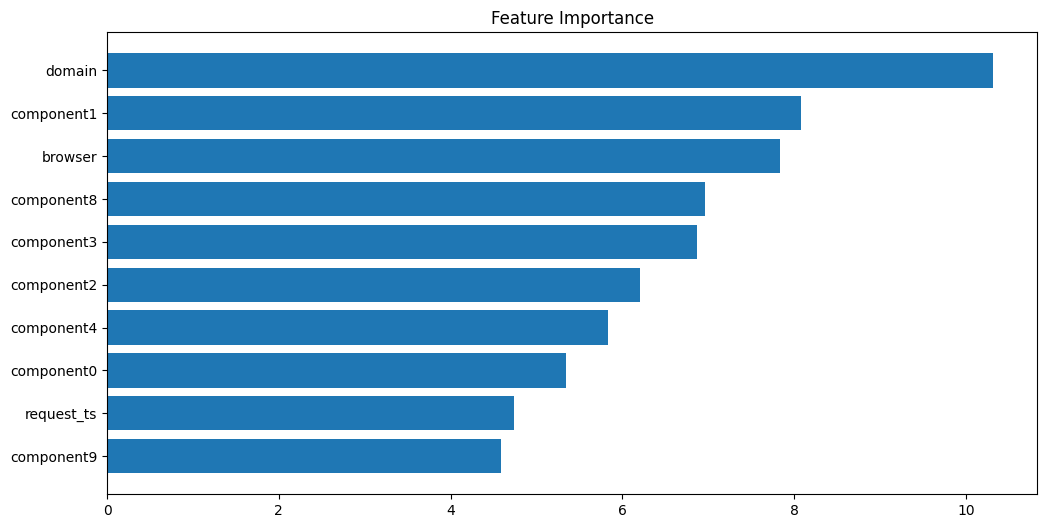

In [37]:
feature_importance = model.feature_importances_
feature_importance_indexes = np.argsort(feature_importance)[-10:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(feature_importance_indexes)), feature_importance[feature_importance_indexes])
plt.yticks(range(len(feature_importance_indexes)), np.array(X_train.columns)[feature_importance_indexes])
plt.title("Feature Importance")
plt.show()

# SHAP 

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train, y_train)

In [ ]:
shap.plots.beeswarm(shap_values)